# <center>Death prediction based on the VAERS post vaccine adverse reactions</center>

*<center>Szymon Szewczyk, Łukasz Szyszka</center>*

*<center>July 10, 2024</center>*

---

## Introduction

aaa

## Data Source

aaa

## Data Preprocessing

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
# from .autonotebook import tqdm as notebook_tqdm

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_data = pd.read_csv("../dane/2022VAERSDATA.csv", encoding='latin1', low_memory=False)
df_vax = pd.read_csv("../dane/2022VAERSVAX.csv", encoding='latin1', low_memory=False)
df = pd.merge(df_data, df_vax, on='VAERS_ID')

df.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')

In [3]:
df = df[['VAERS_ID', "STATE", "CAGE_YR", "SEX", "DIED", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "VAX_TYPE", "VAX_MANU"]]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283454 entries, 0 to 283453
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VAERS_ID  283454 non-null  int64  
 1   STATE     227998 non-null  object 
 2   CAGE_YR   214658 non-null  float64
 3   SEX       283454 non-null  object 
 4   DIED      8248 non-null    object 
 5   HOSPITAL  39676 non-null   object 
 6   HOSPDAYS  23257 non-null   float64
 7   NUMDAYS   228359 non-null  float64
 8   VAX_TYPE  283454 non-null  object 
 9   VAX_MANU  283454 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 23.8+ MB


In [4]:
df = df[df["SEX"].isin(["F", "M"])]
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df = df.dropna(subset=["STATE", "CAGE_YR", "NUMDAYS"])
df['DIED'] = df['DIED'].apply(lambda x: 1 if x == 'Y' else 0)
df['HOSPITAL'] = df['HOSPITAL'].apply(lambda x: 1 if x == 'Y' else 0)
df['HOSPDAYS'] = pd.to_numeric(df['HOSPDAYS'], errors='coerce').fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173665 entries, 208 to 283453
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VAERS_ID  173665 non-null  int64  
 1   STATE     173665 non-null  object 
 2   CAGE_YR   173665 non-null  float64
 3   SEX       173665 non-null  int64  
 4   DIED      173665 non-null  int64  
 5   HOSPITAL  173665 non-null  int64  
 6   HOSPDAYS  173665 non-null  float64
 7   NUMDAYS   173665 non-null  float64
 8   VAX_TYPE  173665 non-null  object 
 9   VAX_MANU  173665 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 14.6+ MB


### Additional constrains

- States
- Age
- Vaccine type

In [5]:
######################### STATES #######################
df = df[df["STATE"] != 'SD']
df = df[df["STATE"] != 'TN']
df = df[df["STATE"] != 'KY']
df = df[df["STATE"] != 'WI']
# df = df[df["STATES"].isin(["TN", "WI", "CA"])]
df = df[df["STATE"].isin(["VA", "AZ", "ME", "MS", "MA", "LA", "CT", "AL", "NV", "KS", "IL", "FL", "MN", "TX", "MO", "NH", "NJ"])]

state_counts = df['STATE'].value_counts()
states_to_keep = state_counts[state_counts >= 200].index
df = df[df['STATE'].isin(states_to_keep)]

######################### AGE ########################
df = df[df["CAGE_YR"] >= 50]
df = df[df["CAGE_YR"] <= 100]

#################### VACCINE TYPE ########################
df = df[df["VAX_TYPE"] == 'COVID19']

#################### VACCINE MANU ########################
df = df[df["VAX_MANU"].isin(["MODERNA", r"PFIZER\BIONTECH"])]

#################### HOSPITAL ########################
# df = df[df["HOSPITAL"] == 1]

#################### HOSPDAYS ########################
df = df[df["HOSPDAYS"] <= 30]

#################### NUMDAYS ########################
# df = df[df["NUMDAYS"] >= 1]
df = df[df["NUMDAYS"] <= 90]

df.describe()

,VAERS_ID,CAGE_YR,SEX,DIED,HOSPITAL,HOSPDAYS,NUMDAYS
count,1.631600e+04,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000
mean,2.256706e+06,65.634714,0.361792,0.018142,0.097879,0.416524,15.132079
std,1.498792e+05,9.937238,0.480534,0.133468,0.297161,2.120104,24.162300
min,1.997131e+06,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.131228e+06,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.257472e+06,65.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.372556e+06,72.000000,1.000000,0.000000,0.000000,0.000000,22.000000
max,2.719846e+06,100.000000,1.000000,1.000000,1.000000,30.000000,90.000000


## Distribution of outcomes

In [7]:
# plt.figure(figsize=(5 , 5))
# plt.hist(x=df["DIED"])
# plt.ylabel('Number of People')
# plt.title('Distribution of Outcome')
# plt.show()

In [8]:
# plt.figure(figsize=(5,5))
# pie_data=df['DIED'].value_counts()
# explode=(0.05,0)
# colors=['moccasin','coral']
# labels=['0-NonDeath','1-Death']
# sns.set(font_scale=1.5)
# plt.pie(pie_data,labels=labels,autopct="%.2f%%",explode=explode,colors=colors)
# plt.legend(labels, loc='lower left')
# plt.title('Proportion of Death and Non-Death Individuals')
# plt.show()

In [9]:
# df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED", "STATE"]].hist(figsize=(20,16), grid=True, bins=50)

In [10]:
# df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED", "STATE"]].plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,10))
# sns.set(font_scale = 1.5)

In [11]:
# fig, ax = plt.subplots(3,2, figsize=(10,10))
# sns.set(font_scale = 1)
# sns.distplot(df.CAGE_YR, ax = ax[0,0], color = 'orange')
# sns.distplot(df.SEX, ax = ax[0,1], color = 'red')
# sns.distplot(df.HOSPDAYS, ax = ax[1,0], color = 'seagreen')
# sns.distplot(df.HOSPITAL, ax = ax[1,1], color = 'purple')
# sns.distplot(df.NUMDAYS, ax = ax[2,0], color = 'deeppink')
# sns.distplot(df.DIED, ax = ax[2,1], color = 'brown')

In [6]:
corr = df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]].corr()
# corr

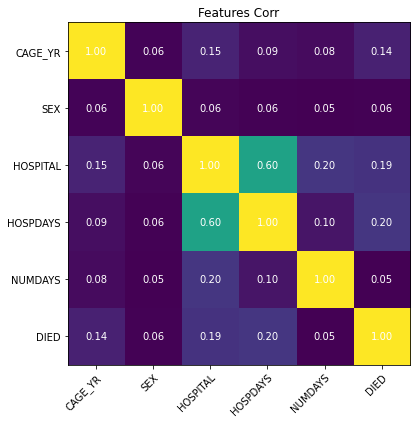

In [7]:
# plt.figure(figsize=(15,10))
# sns.set(font_scale = 1.5)
# sns.heatmap(corr, annot = True, cmap = 'plasma', vmin = -1, vmax = 1, linecolor='white', linewidths= 1)
cor = ["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(corr)

ax.set_xticks(np.arange(len(cor)), labels=cor)
ax.set_yticks(np.arange(len(cor)), labels=cor)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(cor)):
    for j in range(len(cor)):
        text = ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_title("Features Corr")
fig.tight_layout()
plt.show()

In [14]:
# sns.set(font_scale = 1.5)
# sns.pairplot(data=df, hue='DIED', diag_kind='kde', palette='Set2')

# Model 1

## Article Prior

In [8]:
df_data_2020 = pd.read_csv("../dane/2020VAERSDATA.csv", encoding='latin1', low_memory=False)
df_vax_2020 = pd.read_csv("../dane/2020VAERSVAX.csv", encoding='latin1', low_memory=False)
df_2020 = pd.merge(df_data_2020, df_vax_2020, on='VAERS_ID')

df_data_2021 = pd.read_csv("../dane/2021VAERSDATA.csv", encoding='latin1', low_memory=False)
df_vax_2021 = pd.read_csv("../dane/2021VAERSVAX.csv", encoding='latin1', low_memory=False)
df_2021 = pd.merge(df_data_2021, df_vax_2021, on='VAERS_ID')

df_article = pd.concat([df_2020, df_2021])
df_article = df_article.set_index('VAERS_ID')

In [9]:
df_article['RECVDATE'] = pd.to_datetime(df_article['RECVDATE'], format='%m/%d/%Y')

start_date = '2020-12-14'
end_date = '2021-01-22'

df_article = df_article[(df_article['RECVDATE'] >= start_date) & (df_article['RECVDATE'] <= end_date)]

df_article = df_article[["STATE", "CAGE_YR", "SEX", "DIED", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "VAX_TYPE", "VAX_MANU"]]

df_article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64921 entries, 901875 to 2642529
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STATE     52156 non-null  object 
 1   CAGE_YR   56362 non-null  float64
 2   SEX       64921 non-null  object 
 3   DIED      349 non-null    object 
 4   HOSPITAL  1044 non-null   object 
 5   HOSPDAYS  653 non-null    float64
 6   NUMDAYS   60416 non-null  float64
 7   VAX_TYPE  64921 non-null  object 
 8   VAX_MANU  64921 non-null  object 
dtypes: float64(3), object(6)
memory usage: 5.0+ MB


In [10]:
df_article = df_article[df_article["SEX"].isin(["F", "M"])]
df_article['SEX'] = df_article['SEX'].apply(lambda x: 1 if x == 'M' else 0)
df_article = df_article.dropna(subset=["STATE", "CAGE_YR", "NUMDAYS"])
df_article['DIED'] = df_article['DIED'].apply(lambda x: 1 if x == 'Y' else 0)
df_article['HOSPITAL'] = df_article['HOSPITAL'].apply(lambda x: 1 if x == 'Y' else 0)
df_article['HOSPDAYS'] = pd.to_numeric(df_article['HOSPDAYS'], errors='coerce').fillna(0)

df_article = df_article[df_article["NUMDAYS"] <= 90]

df_article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45649 entries, 901875 to 2642010
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STATE     45649 non-null  object 
 1   CAGE_YR   45649 non-null  float64
 2   SEX       45649 non-null  int64  
 3   DIED      45649 non-null  int64  
 4   HOSPITAL  45649 non-null  int64  
 5   HOSPDAYS  45649 non-null  float64
 6   NUMDAYS   45649 non-null  float64
 7   VAX_TYPE  45649 non-null  object 
 8   VAX_MANU  45649 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 3.5+ MB


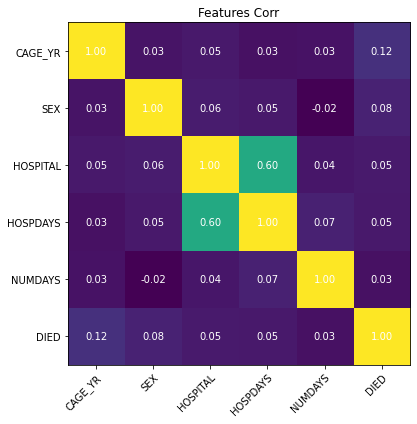

In [11]:
corr_article = df_article[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]].corr()

cor = ["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(corr_article)

ax.set_xticks(np.arange(len(cor)), labels=cor)
ax.set_yticks(np.arange(len(cor)), labels=cor)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(cor)):
    for j in range(len(cor)):
        text = ax.text(j, i, f"{corr_article.iloc[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_title("Features Corr")
fig.tight_layout()
plt.show()

In [12]:
df_article.describe()

,CAGE_YR,SEX,DIED,HOSPITAL,HOSPDAYS,NUMDAYS
count,45649.000000,45649.000000,45649.000000,45649.000000,45649.000000,45649.000000
mean,45.371837,0.193104,0.006134,0.017613,0.035247,2.026375
std,16.623778,0.394738,0.078079,0.131540,0.439273,4.233492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,104.000000,1.000000,1.000000,1.000000,30.000000,90.000000


In [31]:
model_ppc_art = CmdStanModel(stan_file='../models/model_1_prior_art.stan')

R = 100
dict = {
        "N": len(df_article),
        "sex": df_article["SEX"],
        "age": df_article["CAGE_YR"]
}

sim_data_art = model_ppc_art.sample(data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

INFO:cmdstanpy:compiling stan file /root/models/model_1_prior_art.stan to exe file /root/models/model_1_prior_art
INFO:cmdstanpy:compiled model executable: /root/models/model_1_prior_art
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                    


INFO:cmdstanpy:CmdStan done processing.


In [32]:
sim_prior_model_1_1 = sim_data_art.draws_pd()

death_pred_prior_1_1 = sim_data_art.stan_variable("death")
p_1_1 = sim_data_art.stan_variable("p")
alpha_1_1 = sim_data_art.stan_variable("alpha")
beta_age_1_1 = sim_data_art.stan_variable("beta_age")
beta_sex_1_1 = sim_data_art.stan_variable("beta_sex")

In [33]:
death_pred_prior_1_1.shape

(100, 45649)

In [34]:
death_pred_mean_art = np.mean(death_pred_prior_1_1, axis=0)
p_1_1 = np.mean(p_1_1, axis=0)
death_pred_prior_1_1_ = death_pred_prior_1_1.flatten()

In [43]:
print(death_pred_mean_art.mean()*100)
print(df_article["DIED"].mean()*100)
# print(p_1_1.mean())

0.5988959232403778
0.6133759775679642


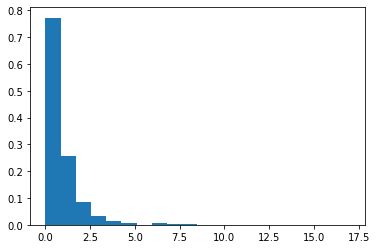

In [36]:
plt.hist(death_pred_mean_art*100,bins=20, density=True)
plt.show()

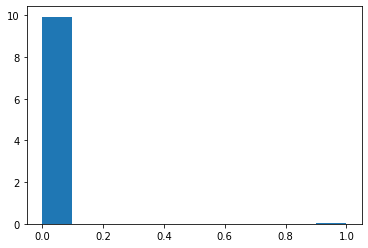

In [37]:
plt.hist(death_pred_prior_1_1_, density=True)
plt.show()

## Data Prior

In [38]:
model_ppc_real = CmdStanModel(stan_file='../models/model_1_prior_real.stan')

INFO:cmdstanpy:compiling stan file /root/models/model_1_prior_real.stan to exe file /root/models/model_1_prior_real
INFO:cmdstanpy:compiled model executable: /root/models/model_1_prior_real


In [39]:
R = 1000
dict = {
        "N": len(df),
        "sex": df["SEX"],
        "age": df["CAGE_YR"]
}

sim_data_real = model_ppc_real.sample(data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:09 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [40]:
sim_prior_model_1_2 = sim_data_real.draws_pd()

death_pred_prior_1_2 = sim_data_real.stan_variable("death")
p_1_2 = sim_data_real.stan_variable("p")
alpha_1_2 = sim_data_real.stan_variable("alpha")
beta_age_1_2 = sim_data_real.stan_variable("beta_age")
beta_sex_1_2 = sim_data_real.stan_variable("beta_sex")

In [30]:
death_pred_real_1 = np.mean(death_pred_prior_1_2, axis=0)
p_1_2 = np.mean(p_1_2, axis=0)
# death_pred_prior_1_2_ = death_pred_prior_1_2.flatten()
print(death_pred_real_1.mean()*100)
print(df["DIED"].mean()*100)

1.769398136798235
1.8141701397401324


In [41]:
death_pred_real_1

array([0.005, 0.005, 0.013, ..., 0.008, 0.008, 0.008])

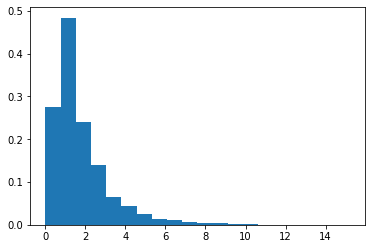

In [42]:
plt.hist(death_pred_real_1*100, bins=20, density=True)
# plt.hist(p_1_2, density=True)
# plt.hist(df["DIED"], density=True)
plt.show()

## Data Posterion

In [44]:
model_1_posterior = CmdStanModel(stan_file='../models/model_1_posterior.stan')

INFO:cmdstanpy:compiling stan file /root/models/model_1_posterior.stan to exe file /root/models/model_1_posterior
INFO:cmdstanpy:compiled model executable: /root/models/model_1_posterior


In [45]:
R = 1000
dict = {
        "N": len(df),
        "age": df["CAGE_YR"],
        "sex": df["SEX"],
        "death": df["DIED"]
    }

fit = model_1_posterior.sample(data=dict, seed=42)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:13 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:18 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:23 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:27 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:31 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:34 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:37 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:41 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:45 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:49 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:54 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:59 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 01:03 Iteration: 1300 / 2000 [ 65%] 


INFO:cmdstanpy:CmdStan done processing.


In [46]:
death_pred_posterior = fit.stan_variable("death_pred")

In [47]:
death_pred_mean = np.mean(death_pred_posterior, axis=0)
death_pred_flat = death_pred_posterior.flatten()

In [48]:
print(death_pred_mean.mean()*100)
print(df["DIED"].mean()*100)

1.835934052463839
1.8141701397401324


In [49]:
death_pred_posterior.max()

1.0

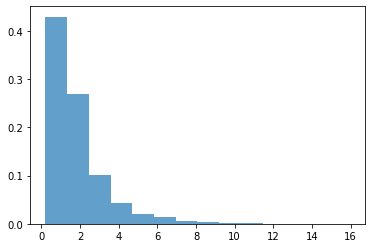

In [50]:
plt.hist(death_pred_mean*100, bins=14, density=True, alpha=0.7)
# plt.hist(df["DIED"], density=True, alpha=0.5)
plt.show()

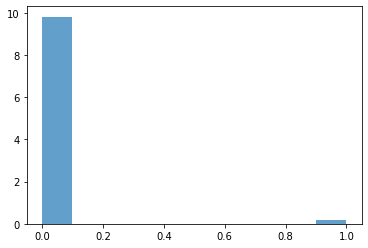

In [52]:
plt.hist(death_pred_flat, density=True, alpha=0.7)
plt.show()

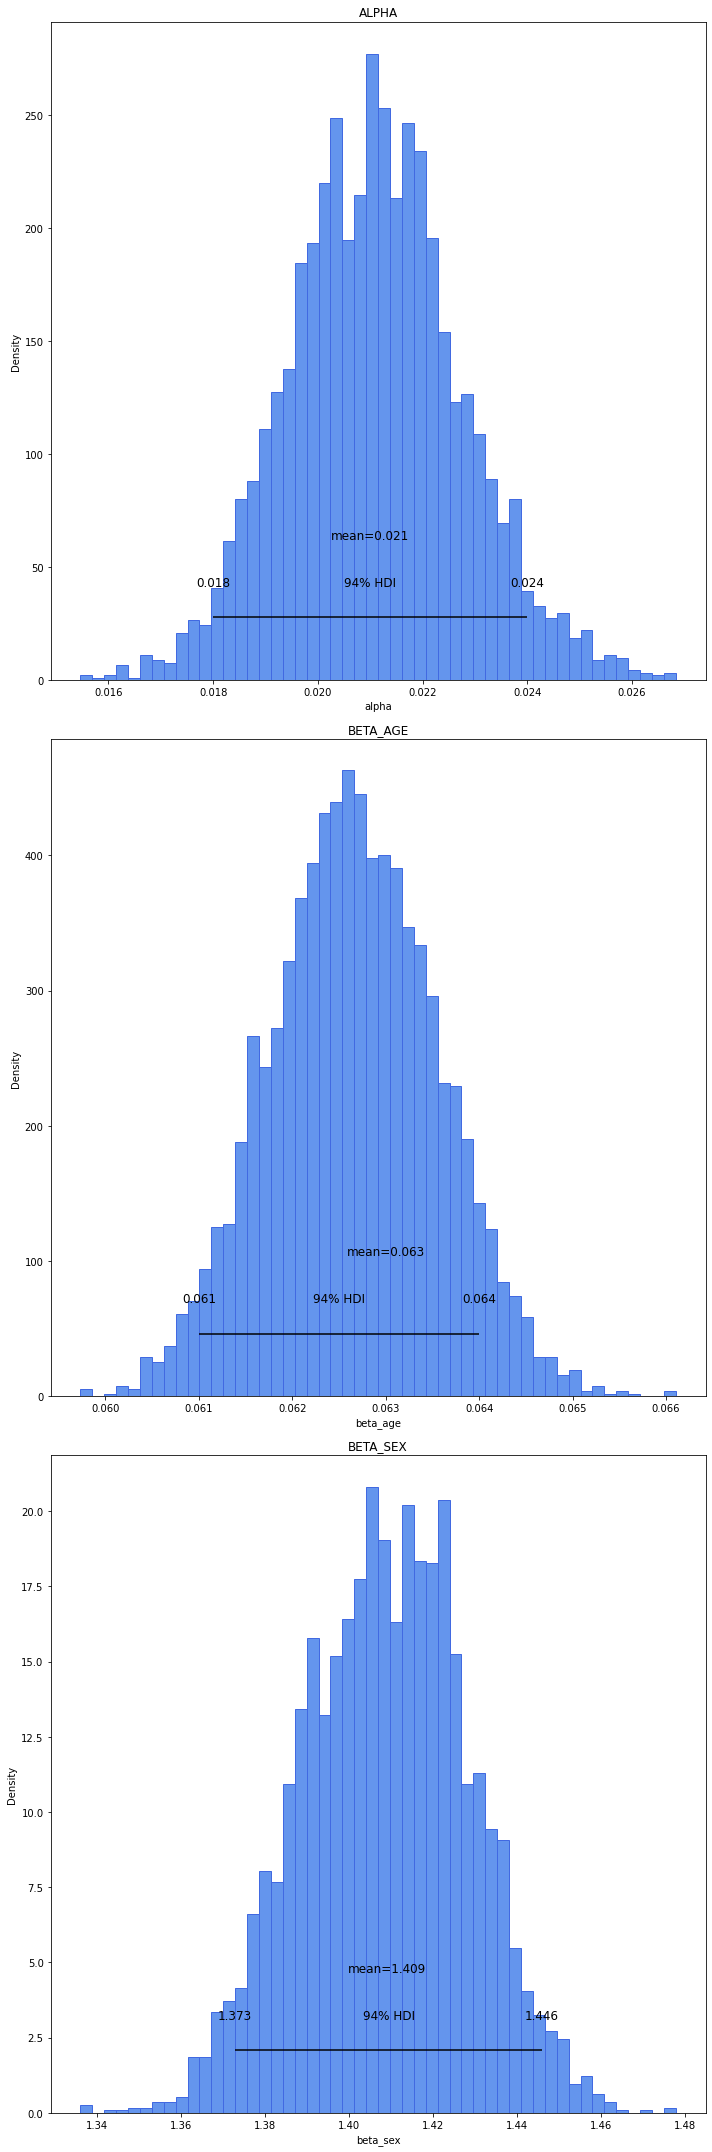

In [53]:
param_names = ['alpha', 'beta_age', 'beta_sex']

n_params = len(param_names)
n_rows, n_cols = n_params, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))


for i, param_name in enumerate(param_names):
    param_values = fit.stan_variable(param_name)

    counts, bins, patches = axes[i].hist(param_values.flatten(), bins=50, color='cornflowerblue', edgecolor='royalblue', density=True)

    statistics = az.summary(fit, var_names=[param_name], kind='stats', hdi_prob=0.94)

    hdi_l = statistics.loc[param_name, 'hdi_3%']
    hdi_h = statistics.loc[param_name, 'hdi_97%']
    mean = statistics.loc[param_name, 'mean']
    
    max_count = max(counts)
    y_hdi = max_count * 0.1
    y_annotate = max_count * 0.15

    # Plot HDI line and annotations
    axes[i].hlines(y=y_hdi, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[i].annotate(f'{hdi_l:.3f}', xy=(hdi_l, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'{hdi_h:.3f}', xy=(hdi_h, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate('94% HDI', xy=((hdi_l + hdi_h) / 2, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'mean={mean:.3f}', xy=(mean, y_annotate * 1.5), xycoords='data', fontsize=12, horizontalalignment='center')
    
    axes[i].set_title(param_name.upper())
    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('Density')

fig.tight_layout()
plt.show()

# Model 2
## Article prior

In [54]:
model_2_ppc_art = CmdStanModel(stan_file='../models/model_2_prior_art.stan')

INFO:cmdstanpy:compiling stan file /root/models/model_2_prior_art.stan to exe file /root/models/model_2_prior_art
INFO:cmdstanpy:compiled model executable: /root/models/model_2_prior_art


In [55]:
R = 1000
dict = {
        "N": len(df_article),
        "sex": df_article["SEX"],
        "age": df_article["CAGE_YR"],
        "hospital_days" : df_article["HOSPDAYS"]
}

sim_data_art_2 = model_2_ppc_art.sample(data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:26 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [56]:
sim_prior_model_2_1 = sim_data_art_2.draws_pd()

death_pred_prior_2_1 = sim_data_art_2.stan_variable("death")
p_2_1 = sim_data_art_2.stan_variable("p")
a_2 = sim_data_art_2.stan_variable("a")
b_2 = sim_data_art_2.stan_variable("b")
c_2 = sim_data_art_2.stan_variable("c")
d_2 = sim_data_art_2.stan_variable("d")
# e_2 = sim_data_art_2.stan_variable("e")
f_2 = sim_data_art_2.stan_variable("f")

In [59]:
death_pred_mean_2_art = np.mean(death_pred_prior_2_1, axis=0)
death_pred_prior_2_1_ = death_pred_prior_2_1.flatten()

In [60]:
print(death_pred_mean_2_art.mean())
print(df_article["DIED"].mean())

0.005804114000306688
0.006133759775679643


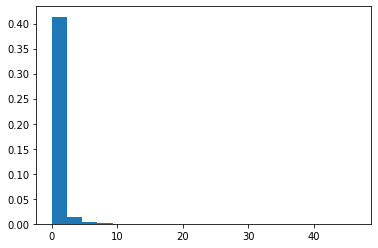

In [61]:
plt.hist(death_pred_mean_2_art*100, bins=20, density=True)
plt.show()

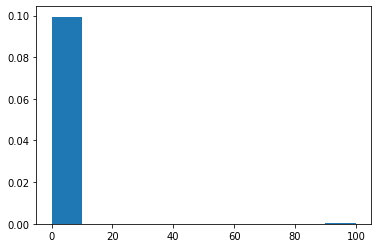

In [62]:
plt.hist(death_pred_prior_2_1_*100, density=True)
plt.show()

## Data prior

In [87]:
model_2_ppc_real = CmdStanModel(stan_file='../models/model_2_prior_real.stan')

INFO:cmdstanpy:compiling stan file /root/models/model_2_prior_real.stan to exe file /root/models/model_2_prior_real
INFO:cmdstanpy:compiled model executable: /root/models/model_2_prior_real


In [90]:
R = 1000
dict = {
        "N": len(df),
        "sex": df["SEX"],
        "age": df["CAGE_YR"],
        "hospital_days" : df["HOSPDAYS"]
}

sim_data_real_2 = model_2_ppc_real.sample(data=dict,
                        iter_sampling=R,
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:09 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [91]:
sim_prior_model_2_2 = sim_data_real_2.draws_pd()

death_pred_prior_2_2 = sim_data_real_2.stan_variable("death")
p_2_2 = sim_data_real_2.stan_variable("p")
a_2_2 = sim_data_real_2.stan_variable("a")
b_2_2 = sim_data_real_2.stan_variable("b")
c_2_2 = sim_data_real_2.stan_variable("c")
d_2_2 = sim_data_real_2.stan_variable("d")
# e_2_2 = sim_data_real_2.stan_variable("e")
f_2_2 = sim_data_real_2.stan_variable("f")

In [94]:
death_pred_real_2_mean = np.mean(death_pred_prior_2_2, axis=0)
death_pred_real_2_flat = death_pred_prior_2_2.flatten()
p_2_2 = np.mean(p_2_2, axis=0)

print(death_pred_real_2_mean.mean())
print(df["DIED"].mean())

0.018034076979651877
0.018141701397401323


In [108]:
death_pred_real_2_mean.max()

0.875

In [122]:
new = [el>=0.5 for el in death_pred_real_2_mean]
sum(new)

13

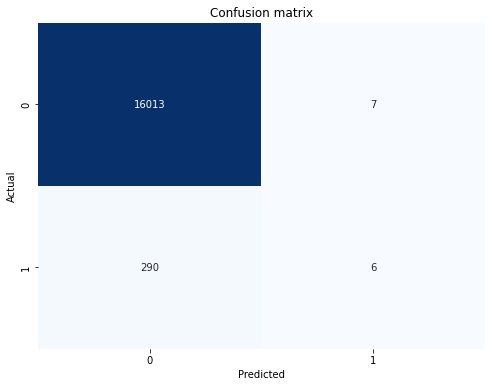

In [123]:
from sklearn.metrics import  roc_curve, auc ,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(df['DIED'], new)
precision = precision_score(df['DIED'], new)
recall = recall_score(df["DIED"], new)
f1 = f1_score(df["DIED"], new)

conf_matrix = confusion_matrix(df["DIED"], new)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

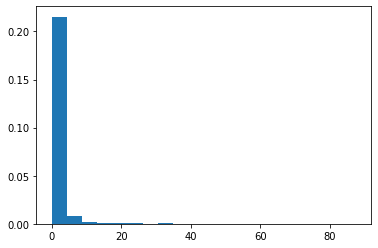

In [96]:
plt.hist(death_pred_real_2_mean*100, bins=20, density=True)
# plt.hist(p_1_2, density=True)
# plt.hist(df["DIED"], density=True)
plt.show()

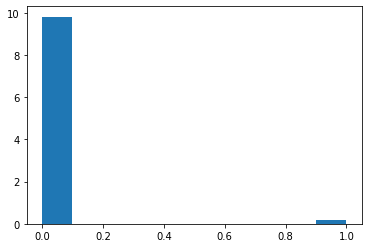

In [97]:
plt.hist(death_pred_real_2_flat, density=True)
# plt.hist(p_1_2, density=True)
# plt.hist(df["DIED"], density=True)
plt.show()

## Data Posterior

In [98]:
model_2_posterior = CmdStanModel(stan_file='../models/model_2_posterior.stan')

INFO:cmdstanpy:compiling stan file /root/models/model_2_posterior.stan to exe file /root/models/model_2_posterior
INFO:cmdstanpy:compiled model executable: /root/models/model_2_posterior


In [99]:
R = 1000
dict = {
        "N": len(df),
        "age": df["CAGE_YR"],
        "sex": df["SEX"],
        "hospital_days": df["HOSPDAYS"],
        "death": df["DIED"]
    }

fit_2 = model_2_posterior.sample(data=dict, seed=42)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:11 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▋       | 00:27 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 01:42 Iteration:  500 / 2000 [ 25%]  (Warmup)
































chain 1 |███▋      | 10:32 Iteration:  600 / 2000 [ 30%]  (Warmup)


















chain 1 |██████████| 22:17 Sampling completed                       
chain 2 |██████████| 22:17 Sampling completed                       
chain 3 |██████████| 22:17 Sampling completed                       
chain 4 |██████████| 22:17 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [101]:
death_pred_posterior_2 = fit_2.stan_variable("death_pred")

In [102]:
death_pred_mean_2 = np.mean(death_pred_posterior_2, axis=0)
death_pred_flat_2 = death_pred_posterior_2.flatten()

In [103]:
print(death_pred_mean_2.mean()*100)
print(df["DIED"].mean()*100)

1.4048234861485658
1.8141701397401324


In [124]:
new_2 = [el>=0.5 for el in death_pred_mean_2]
sum(new_2)

15

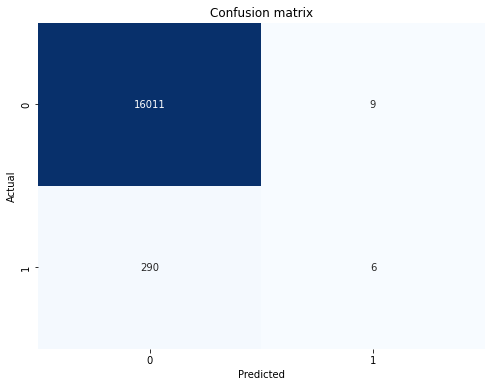

In [125]:
accuracy = accuracy_score(df['DIED'], new_2)
precision = precision_score(df['DIED'], new_2)
recall = recall_score(df["DIED"], new_2)
f1 = f1_score(df["DIED"], new_2)

conf_matrix = confusion_matrix(df["DIED"], new_2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

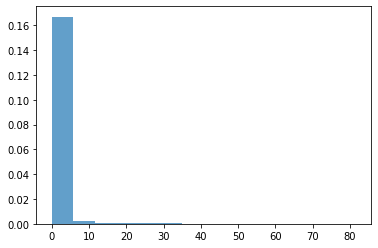

In [104]:
plt.hist(death_pred_mean_2*100, bins=14, density=True, alpha=0.7)
# plt.hist(df["DIED"], density=True, alpha=0.5)
plt.show()

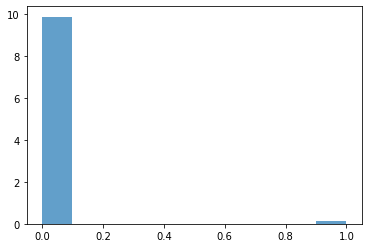

In [105]:
plt.hist(death_pred_flat_2, density=True, alpha=0.7)
plt.show()

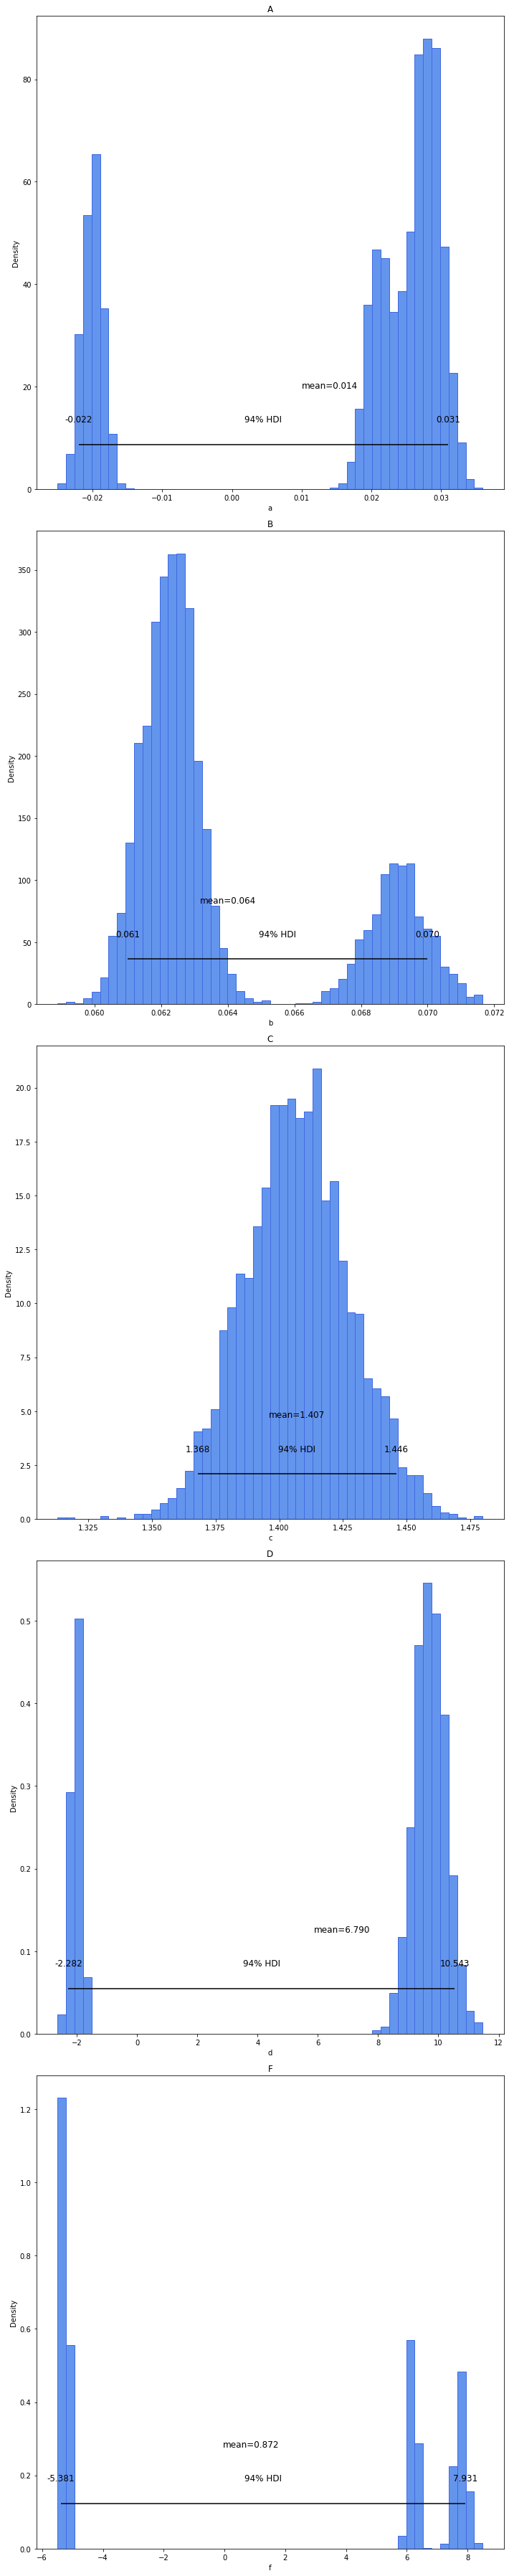

In [107]:
param_names = ['a', 'b', 'c', 'd', 'f']

n_params = len(param_names)
n_rows, n_cols = n_params, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))


for i, param_name in enumerate(param_names):
    param_values = fit_2.stan_variable(param_name)

    counts, bins, patches = axes[i].hist(param_values.flatten(), bins=50, color='cornflowerblue', edgecolor='royalblue', density=True)

    statistics = az.summary(fit_2, var_names=[param_name], kind='stats', hdi_prob=0.94)

    hdi_l = statistics.loc[param_name, 'hdi_3%']
    hdi_h = statistics.loc[param_name, 'hdi_97%']
    mean = statistics.loc[param_name, 'mean']
    
    max_count = max(counts)
    y_hdi = max_count * 0.1
    y_annotate = max_count * 0.15

    # Plot HDI line and annotations
    axes[i].hlines(y=y_hdi, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[i].annotate(f'{hdi_l:.3f}', xy=(hdi_l, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'{hdi_h:.3f}', xy=(hdi_h, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate('94% HDI', xy=((hdi_l + hdi_h) / 2, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'mean={mean:.3f}', xy=(mean, y_annotate * 1.5), xycoords='data', fontsize=12, horizontalalignment='center')
    
    axes[i].set_title(param_name.upper())
    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('Density')

fig.tight_layout()
plt.show()

# Model 3

In [130]:
model_3_posterior = CmdStanModel(stan_file='../models/model_2_posterior.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [131]:
R = 1000
dict = {
        "N": len(df),
        "age": df["CAGE_YR"],
        "sex": df["SEX"],
        "hospital_days": df["HOSPDAYS"],
        "death": df["DIED"]
    }

fit_3 = model_3_posterior.sample(data=dict, seed=42, iter_sampling=500, iter_warmup=500, chains=4, parallel_chains=4, refresh=100)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▊         | 00:00 Status





chain 1 |█▋        | 00:05 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:12 Iteration: 100 / 1000 [ 10%]  (Warmup)
chain 1 |█████▊    | 00:29 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 05:28 Iteration: 501 / 1000 [ 50%]  (Sampling)






















chain 1 |██████████| 28:42 Sampling completed                      
chain 2 |██████████| 28:42 Sampling completed                      
chain 3 |██████████| 28:42 Sampling completed                      
chain 4 |██████████| 28:42 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


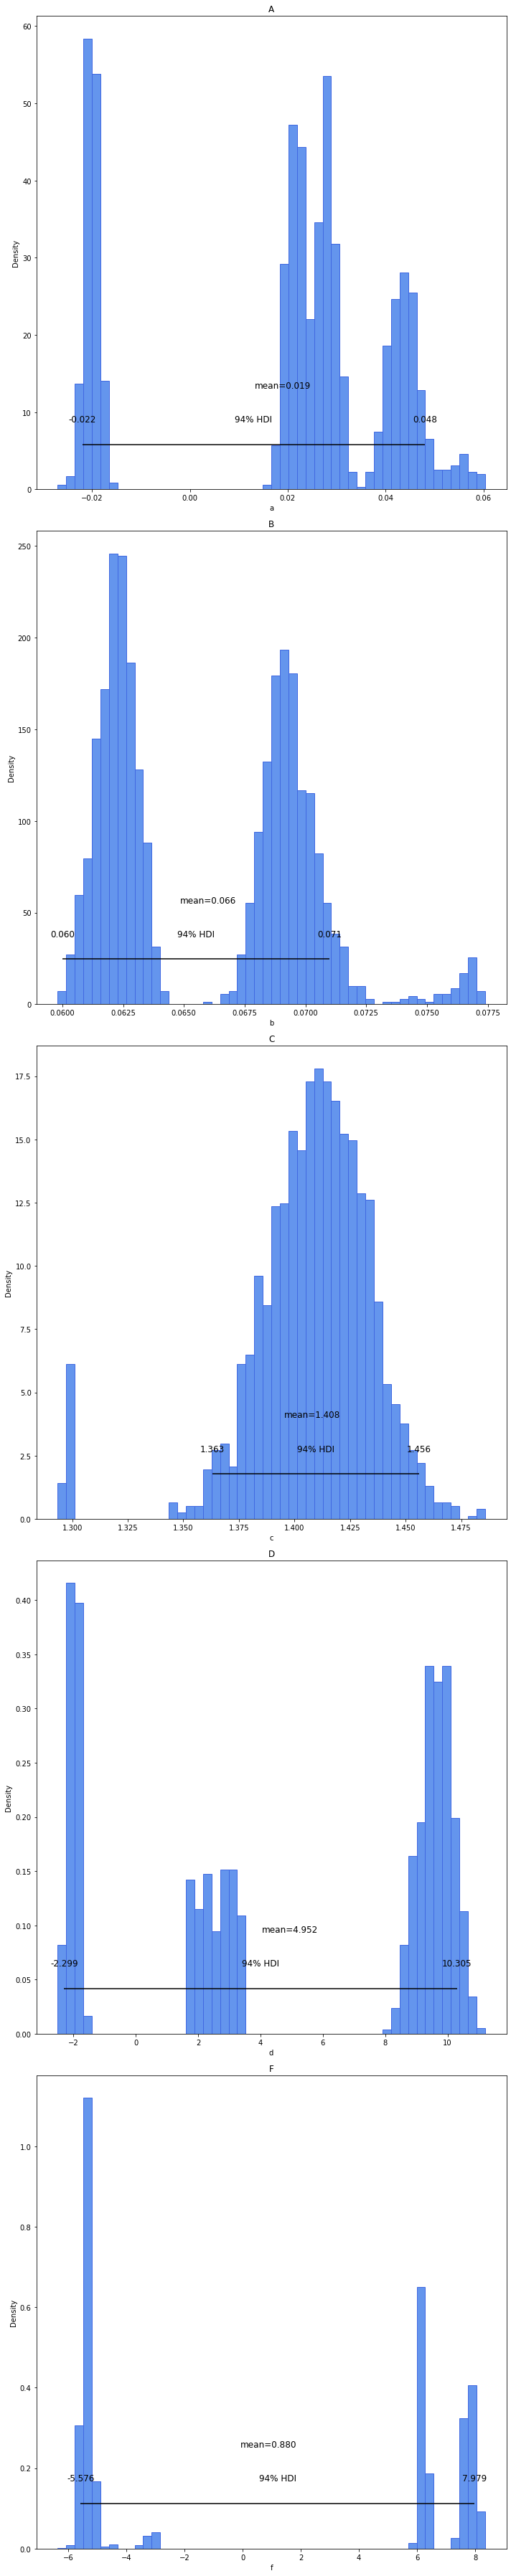

In [132]:
param_names = ['a', 'b', 'c', 'd', 'f']

n_params = len(param_names)
n_rows, n_cols = n_params, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 10*n_rows))


for i, param_name in enumerate(param_names):
    param_values = fit_3.stan_variable(param_name)

    counts, bins, patches = axes[i].hist(param_values.flatten(), bins=50, color='cornflowerblue', edgecolor='royalblue', density=True)

    statistics = az.summary(fit_3, var_names=[param_name], kind='stats', hdi_prob=0.94)

    hdi_l = statistics.loc[param_name, 'hdi_3%']
    hdi_h = statistics.loc[param_name, 'hdi_97%']
    mean = statistics.loc[param_name, 'mean']
    
    max_count = max(counts)
    y_hdi = max_count * 0.1
    y_annotate = max_count * 0.15

    # Plot HDI line and annotations
    axes[i].hlines(y=y_hdi, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[i].annotate(f'{hdi_l:.3f}', xy=(hdi_l, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'{hdi_h:.3f}', xy=(hdi_h, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate('94% HDI', xy=((hdi_l + hdi_h) / 2, y_annotate), xycoords='data', fontsize=12, horizontalalignment='center')
    axes[i].annotate(f'mean={mean:.3f}', xy=(mean, y_annotate * 1.5), xycoords='data', fontsize=12, horizontalalignment='center')
    
    axes[i].set_title(param_name.upper())
    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('Density')

fig.tight_layout()
plt.show()

# Comp

<AxesSubplot:xlabel='Deviance'>

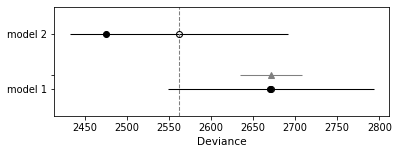

In [128]:
comp_dict = {"model 1":fit, "model 2": fit_2}
comp_loo = az.compare(comp_dict, ic="loo", scale="deviance")
az.plot_compare(comp_loo)

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<AxesSubplot:xlabel='Deviance'>

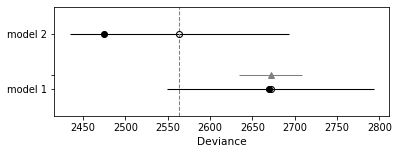

In [129]:
comp_waic = az.compare(comp_dict, ic="waic",scale="deviance")
az.plot_compare(comp_waic)